In [1]:
%load_ext autoreload
%autoreload 2

In [118]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import statsmodels.formula.api as smf

from wordcloud import WordCloud
from src.scripts.article_to_country import *

from src.data.dataloader import *
from src.utils.plots import *
from src.utils.functions import *
from src.scripts.articles_clicks_links import click_count_in_paths
from country_list import countries_for_language
from itertools import combinations
import plotly.express as px


In [119]:
results = {}
country_data = pd.read_csv('data/country_data.csv', index_col=0)
counts = filter_top_k(country_data, k=2, N=1)
total_number_of_articles = len(counts)

nan_df = counts[counts.isna().all(axis=1)]
print(f"Number of articles with no countries before completion with llama: {len(nan_df)}")
results["naïve"] = (total_number_of_articles - len(nan_df)) / total_number_of_articles

refined_data = pd.read_csv("data/country_occurences.csv", index_col=0)
nan_df = refined_data[refined_data.isna().all(axis=1)]
print(f"Number of articles with no countries after completion with naive + llama: {len(nan_df)}")
results["naïve + LlaMa"] = (total_number_of_articles - len(nan_df)) / total_number_of_articles

qwen_country_data = pd.read_csv('data/country_data_full_qwen.csv', index_col=0)
qwen_missing = len(qwen_country_data[qwen_country_data["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with QWEN: {qwen_missing}")
results["Qwen"] = (total_number_of_articles - qwen_missing) / total_number_of_articles


llama_country_data = pd.read_csv('data/country_data_full_llama.csv', index_col=0)
llama_missing = len(llama_country_data[llama_country_data["Top_1_name"].isna()])
print(f"Number of articles with no countries after completion with LLAMA: {llama_missing}")
results["LlaMa"] = (total_number_of_articles - llama_missing) / total_number_of_articles


Number of articles with no countries before completion with llama: 1412
Number of articles with no countries after completion with naive + llama: 283
Number of articles with no countries after completion with QWEN: 2905
Number of articles with no countries after completion with LLAMA: 479


In [120]:

# qwen_country_data = pd.read_csv('data/country_data_full_qwen.csv', index_col=0)
# countries = list(dict(countries_for_language('en')).values())

# for idx, row in qwen_country_data.iterrows():
#     if not pd.isna(row['Top_1_name']):
#         for country in countries:
#             if country.lower() in row['Top_1_name'].lower():
#                 qwen_country_data.at[idx, 'Top_1_name'] = country.lower()
#                 break
# qwen_country_data.to_csv('data/country_data_full_qwen.csv')

In [121]:

# qwen_country_data = pd.read_csv('data/country_data_full_llama.csv', index_col=0)
# countries = list(dict(countries_for_language('en')).values())

# for idx, row in qwen_country_data.iterrows():
#     if not pd.isna(row['Top_1_name']):
#         for country in countries:
#             if country.lower() in row['Top_1_name'].lower():
#                 qwen_country_data.at[idx, 'Top_1_name'] = country.lower()
#                 break
# qwen_country_data.to_csv('data/country_data_full_llama.csv')

In [130]:
fig = px.bar(x=results.keys(), y=results.values())
fig.update_layout(title="Proportion of articles assigned to a country")
fig.update_yaxes(range=[0, 1])
fig.show()
fig.write_html("test_plt.html")

Text(0, 0.5, '% of articles assigned to a country')

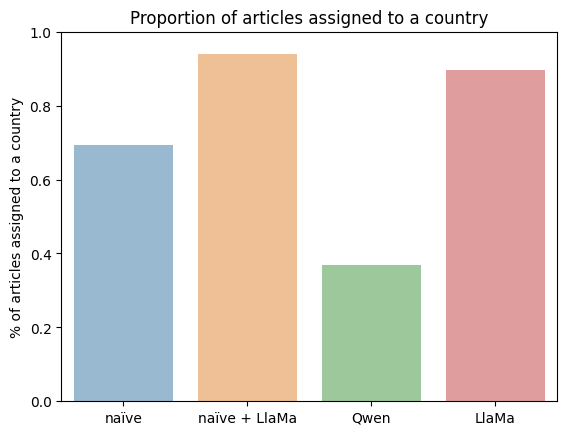

In [116]:
sns.barplot(x=results.keys(), y=results.values(),  alpha=0.5, hue=results.keys(), )
plt.ylim(0, 1)
plt.title("Proportion of articles assigned to a country")
plt.ylabel("% of articles assigned to a country")

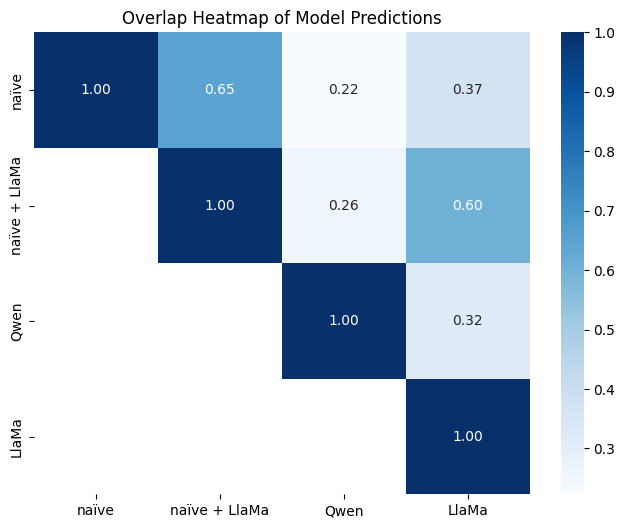

In [117]:
models = {
    "naïve": counts,
    "naïve + LlaMa": refined_data,
    "Qwen": qwen_country_data,
    "LlaMa": llama_country_data
}

heatmap_data = pd.DataFrame(index=models, columns=models)

for model in models.keys():
    heatmap_data.loc[model, model] = 1.0

for model1, model2 in combinations(models.keys(), 2):
    df_1 = models[model1]
    df_2 = models[model2]
    overlap = (df_1["Top_1_name"] == df_2["Top_1_name"]).sum() / total_number_of_articles
    heatmap_data.loc[model1, model2] = overlap
    # heatmap_data.loc[model2, model1] = overlap

# Convert to float
heatmap_data = heatmap_data.astype(float)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap="Blues", cbar=True, fmt=".2f")
plt.title("Overlap Heatmap of Model Predictions")
plt.show()